In [1]:
import pandas as pd

In [17]:
# first load the building + fire data
df = pd.read_csv('third_analysis.csv')

In [3]:
# crime + census
df_crime = pd.read_csv('sf_crime_census.csv')
# link parce with blk
df_joint = pd.read_csv('parcel_blk.csv')

In [5]:
df.columns

Index(['yrbuilt', 'from_st', 'total_uses', 'shape_area', 'cie', 'landuse',
       'mips', 'mapblklot', 'objectid', 'shape_leng', 'visitor', 'st_type',
       'bldgsqft', 'resunits', 'pdr', 'street', 'retail', 'to_st', 'block_num',
       'blklot', 'lot_num', 'med', 'fire_count', 'fire_count_last year',
       'year', 'complaints_count', 'violation_count', 'building_permit'],
      dtype='object')

In [6]:
df_joint.columns

Index(['objectid', 'block_id'], dtype='object')

In [7]:
df_crime.columns

Index(['block_id', 'arson_count', 'other_crime_count', 'year',
       'nodes_population_1500m', 'block_groups_total_jobs',
       'block_groups_median_children', 'block_groups_median_income',
       'prop_tenure_1', 'nodes_low_income_hh_1500m',
       'nodes_high_income_hh_1500m', 'nodes_jobs_3000m', 'nodes_jobs_20km',
       'nodes_population_400m', 'nodes_population_800m',
       'block_groups_prop_race_of_head_1', 'block_groups_prop_race_of_head_2',
       'block_groups_prop_race_of_head_3', 'block_groups_prop_race_of_head_7',
       'block_groups_prop_race_of_head_8', 'block_groups_prop_race_of_head_6',
       'pumas_density_residential_units', 'block_groups_density_jobs',
       'nodes_jobs_1500m_4445', 'nodes_jobs_3000m_4445', 'nodes_du_5000m',
       'nodes_du_800m', 'block_groups_median_rent',
       'block_groups_median_persons', 'block_groups_median_age_of_head',
       'nodes_ave_year_built_800m'],
      dtype='object')

In [11]:
print(df_joint.shape)
print(df_crime.shape)

(158633, 2)
(173243, 31)


In [14]:
# when joining parcel with block, may resulted in duplication
df_joint.duplicated(subset=['objectid']).any()

True

In [15]:
# drop duplicate
df_joint = df_joint.drop_duplicates(subset=['objectid'], keep='first')
print(df_joint.shape)

(155466, 2)


In [18]:
print(df.shape)
# joint df with df_joint on objectid
# then join them with df_crime on block_id and year

df = df.merge(df_joint,on='objectid', how='left')
print(df.shape)

(1243744, 28)
(1243744, 29)


In [19]:
# df_crime is from 2007-2019. need to join by year and block_id
df = df.merge(df_crime,how='left',left_on=['block_id', 'year'], right_on=['block_id','year'])
print(df.shape)

(1243744, 58)


In [21]:
# select columns to use
cols_to_use = ['fire_count','fire_count_last year','year',
               'yrbuilt','bldgsqft','total_uses','cie','mips','visitor', 'pdr', 'retail', 'med','resunits',
               'complaints_count', 'violation_count','building_permit',
              'arson_count', 'other_crime_count', 
               'nodes_population_1500m', 'block_groups_total_jobs',
               'block_groups_median_children', 'block_groups_median_income',
               'prop_tenure_1', 'nodes_low_income_hh_1500m',
               'nodes_high_income_hh_1500m', 'nodes_jobs_3000m', 'nodes_jobs_20km',
               'nodes_population_400m', 'nodes_population_800m',
               'block_groups_prop_race_of_head_1', 'block_groups_prop_race_of_head_2',
               'block_groups_prop_race_of_head_3', 'block_groups_prop_race_of_head_7',
               'block_groups_prop_race_of_head_8', 'block_groups_prop_race_of_head_6',
               'pumas_density_residential_units', 'block_groups_density_jobs',
               'nodes_jobs_1500m_4445', 'nodes_jobs_3000m_4445', 'nodes_du_5000m',
               'nodes_du_800m', 'block_groups_median_rent',
               'block_groups_median_persons', 'block_groups_median_age_of_head',
               'nodes_ave_year_built_800m']

df_model = df[cols_to_use]
print(df_model.shape)
df_model = df_model.dropna(how='any')
print(df_model.shape)

(1243744, 45)
(1123981, 45)


In [22]:
df_model['fire_count'].value_counts()

0.0     1081902
1.0       36564
2.0        3637
3.0         937
4.0         409
5.0         192
6.0         132
7.0          72
8.0          38
9.0          30
10.0         25
12.0          9
11.0          8
14.0          4
19.0          3
22.0          3
16.0          3
15.0          2
18.0          2
23.0          2
27.0          1
21.0          1
32.0          1
39.0          1
37.0          1
26.0          1
30.0          1
Name: fire_count, dtype: int64

In [23]:
# make fire count binary
df_model['fire'] = 0
df_model.loc[(df_model['fire_count'] > 0),'fire'] = 1
df_model.drop('fire_count',inplace=True, axis=1)
df_model['fire'].value_counts()

#3.7% of buildings have fire

0    1081902
1      42079
Name: fire, dtype: int64

In [26]:
df_model['year'].value_counts()

2015    151875
2017    151159
2014    150959
2013    150827
2016    150563
2012    150401
2019    109392
2018    108805
Name: year, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
plt.style.use('seaborn-talk')

In [ ]:
# in sklearn, there are many ways of calculating accuracy of models. Use this command to display them all
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

In [27]:
# divide the data
x_cols = cols_to_use[1:]

validate = df_model[df_model['year']==2019]
traintest = df_model[df_model['year']<2019]

df_x = traintest[x_cols]
df_y = traintest['fire']

# a validation set used for ptrediction
validate_x = validate[x_cols]
validate_y = validate['fire']

In [28]:
def generate_pipeline_RC(scale=False,select=True,test_parameters=False):

    '''
    Set up modelling pipline for random forest classifier
    User selects parameters to conduct grid search and number of folds of CV
    '''

    #Scaling
    SC = StandardScaler()

    #Classifier 
    RC = RandomForestClassifier()
    #Feature selector
    FS = SelectFromModel(estimator=RC,threshold='mean')
    #Pipeline
    if (scale == True) and (select == True):
        RC_pipeline = Pipeline([('scale',SC),('select',FS),('classify', RC)])
    elif (scale == True) and (select == False):
        RC_pipeline = Pipeline([('scale',SC),('classify', RC)])
    elif (scale == False) and (select == True ):
        RC_pipeline = Pipeline([('select',FS),('classify', RC)])
    else:
        RC_pipeline = Pipeline([('classify', RC)])

    if test_parameters == False:

        #Parameters to search over
        test_parameters = {
        'classify__n_estimators': [100],
        'classify__max_depth': [15],
        'classify__min_samples_leaf':[30]
        }

    #Number of folds
    nfolds=5

    #Grid search object to set up
    grid_search = GridSearchCV(RC_pipeline, test_parameters, \
                           scoring='roc_auc',verbose=1, cv=nfolds, n_jobs=4)

    return RC_pipeline, grid_search, test_parameters

In [29]:
def perform_grid_search(pipeline_obj,grid_search_obj,X_train,y_train,test_parameters,Xcols,select=True):
    
    '''
    Perform a grid search over hyperparmeters to generate the best model. Takes a generic pipeline object and grid search
    object. Prints the length of time it takes to run a model. Runs GridSearchCV over some input range of parameters to
    select the best model based in AOC score
    '''
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline_obj.steps])
    print("parameters:")
    print(test_parameters)
    t0 = time.time()
    
    #Do the grid search on the training dataset
    grid_search_obj.fit(X_train, y_train)
    
    print("done in %0.3fs" % (time.time() - t0))
    print()

    print("Best score: %0.3f" % grid_search_obj.best_score_)
    print("Best parameters set:")
    best_estimator = grid_search_obj.best_estimator_
    best_parameters = best_estimator.get_params()
    for param_name in sorted(test_parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    #Get the names of the columns corresponding to the features we want to keep
    if select == True:
        support = best_estimator.named_steps['select'].get_support()
        X_new_cols = [Xcols[i] for i in range(len(support)) if support[i] == True]
    else:
        X_new_cols = Xcols
 
    #Return the best estimator object for use with the holdout dataset
    
    return X_new_cols, best_estimator

In [ ]:
test_parameters_RF = {
        'classify__n_estimators': [100,200],
        'classify__max_depth': [10,15],
        'classify__min_samples_split':[8,20],
        'classify__min_samples_leaf':[20,30.40],
        'classify__class_weight':['balanced','balanced_subsample']
}

pipeline, gridsearch, testparams = generate_pipeline_RC(test_parameters=test_parameters_RF,select=True)

#Run grid search for the best model
Xcols, RF_model_structure = perform_grid_search(pipeline,gridsearch,df_x,df_y,testparams,list(df_x.columns),select=True)

Performing grid search...
pipeline: ['select', 'classify']
parameters:
{'classify__n_estimators': [100, 200], 'classify__max_depth': [10, 15], 'classify__min_samples_split': [8, 20], 'classify__min_samples_leaf': [20, 30.4], 'classify__class_weight': ['balanced', 'balanced_subsample']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 59.5min


In [31]:
def plot_ROC_curve(Xdata,Ytrue,model,title):

    '''
    Plot ROC curve for this model 
    '''

    fires_holdout_predict = model.predict_proba(Xdata)

    fpr, tpr, thresholds1 = roc_curve(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])

    score = roc_auc_score(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])

    score_label = 'AOC score: %.3f' %score 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(fpr,tpr,label=score_label)
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
    ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')
    ax.set_title('%s' %title)

        
    ax.fill_between(fpr, np.zeros(len(fpr)),
                     tpr, alpha=0.1,
                     color="b")
    ax.grid()
    plt.legend(loc='best')
    fname = 'AOC_%s.png' %title
    plt.savefig(fname,dpi=400)

    return fig, fpr, tpr, thresholds1


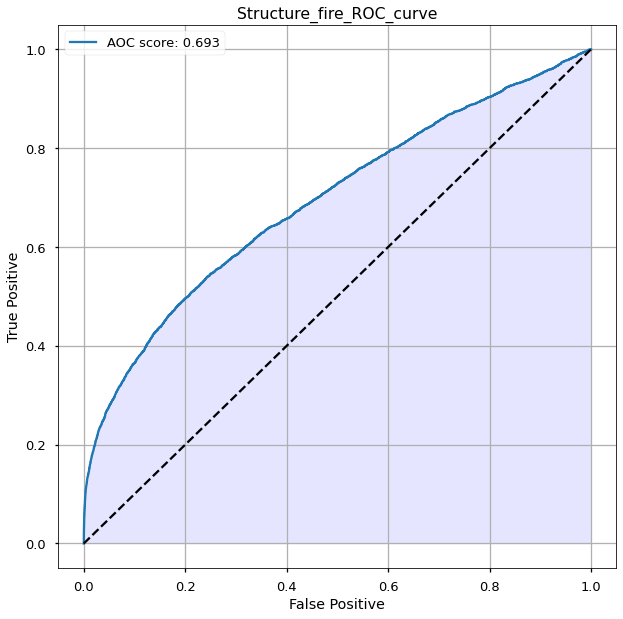

In [32]:
ROCplot, false_positive_EF, true_positive_EF, thresholds_EF = plot_ROC_curve(validate_x,validate_y,
                                                                             RF_model_structure,
                                                                             title='Structure_fire_ROC_curve')

In [33]:
# assess model performance
from sklearn import metrics

In [35]:
fprobs = RF_model_structure.predict_proba(validate_x)
fclass = RF_model_structure.predict(validate_x)
metrics.recall_score(validate_y,fclass)

0.4206122448979592

In [36]:
metrics.precision_score(validate_y,fclass)

0.127230075930613

In [37]:
metrics.f1_score(validate_y,fclass)

0.19536470922792548

In [40]:
feature_importances = RF_model_structure.named_steps['classify'].feature_importances_
inds = feature_importances.argsort()[::-1]
fnames = []
fvals = []
for index in inds:
    fvals.append(feature_importances[index])
    fnames.append(Xcols[index])

Xcols

['fire_count_last year',
 'year',
 'yrbuilt',
 'bldgsqft',
 'total_uses',
 'resunits',
 'other_crime_count',
 'prop_tenure_1']

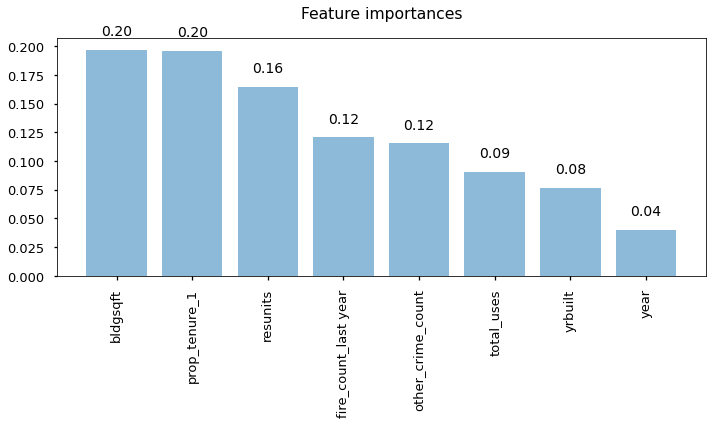

In [41]:
xlabels = fnames
ylabels = fvals

#Better label names for plot
#xlabels = ['#crimes','#external fires','Lon','Area','Lat','#inspections','#residents','year','building_age_sd','landvalue']

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.2f' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
            ha='center', va='bottom', fontsize=14)

plt.xticks(rotation=90)
ax1.set_title("Feature importances",pad=20)
plt.tight_layout()
#plt.savefig("External_fires_fimportance_final.png",dpi=400)

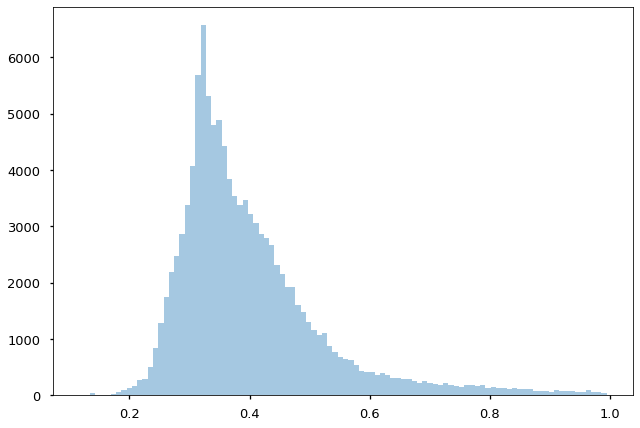

In [43]:
EF_2018_pred = RF_model_structure.predict_proba(validate_x)
#Plot the distribution of fire probabilities 
sns.distplot(EF_2018_pred[:,1],kde=False,bins=100)